In [134]:
#Fetching tweets
from twitterscraper import query_tweets

import datetime as dt 
import time

#Dataframe
import pandas as pd 

# Numpy array
import numpy as np

#Extracting languages
import cld3

#Regex for preprocessing
import re

#Counting
from collections import Counter

#Plotting words
from wordcloud import WordCloud

#Disable pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None;  # default='warn'

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

#Matplotlib and seaborn plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GlobalMaxPool1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Word2vec
import gensim

import spacy

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
#nltk.download('wordnet')
#!pip install pycld3

## Training Twitter model using `Sentiment140` dataset

In [5]:
sent_df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1")
sent_df.columns = ["target", "id", "date", "flag", "user", "text"]
sent_df.head()

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# sent_df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1")
# sent_df.columns = ["target", "id", "date", "flag", "user", "text"]
# sent_df.head()

### Dataset Information
  
- **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- **ids**: The id of the tweet ( 2087)
- **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
- **user**: the user that tweeted (robotickilldozr)
- **text**: the text of the tweet (Lyx is cool)

In [6]:
print("Shape of dataset:", (sent_df).shape)

Shape of dataset: (1599999, 6)


In [7]:
sent_df['target'].unique()

array([0, 4])

### Assigning target labels to sentiments
- **0** -> **negative**
- **4** -> **positive**

In [8]:
sentiment_label = {0: "negative", 4: "positive"}
def sentiment_code(label):
    return sentiment_label[int(label)]

In [9]:
sent_df['target'] = sent_df['target'].apply(lambda x: sentiment_code(x))

In [10]:
sent_df['target'].unique()

array(['negative', 'positive'], dtype=object)

In [11]:
target_counts = Counter(sent_df['target'])

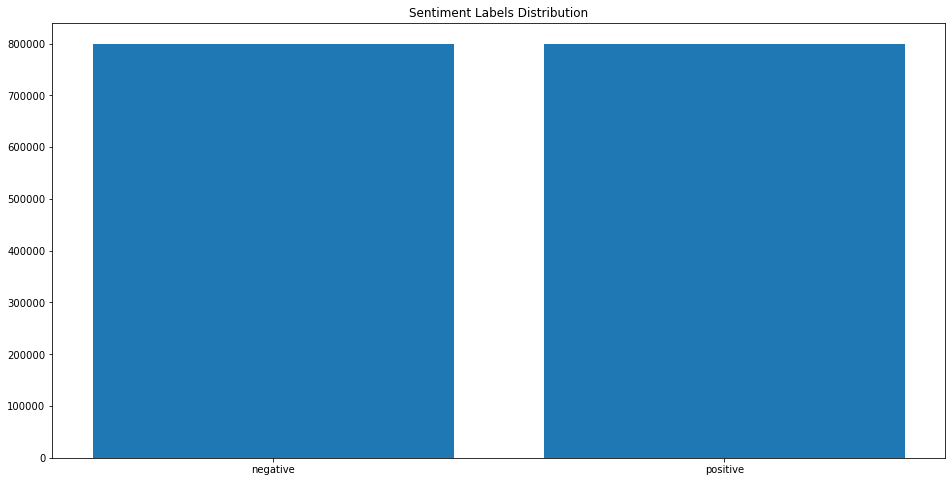

In [12]:
#Plotting
plt.figure(figsize=(16,8))
plt.bar(target_counts.keys(), target_counts.values())
plt.title("Sentiment Labels Distribution")
plt.show()

### Pre-preprocess Data

In [13]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

In [14]:
def preprocess(text, lemmatize=True):
    # Remove url, change to lower case
    text = re.sub('http\S+|www\S+', ' ', str(text).lower())
    # remove picture links 
    text = re.sub('pic\S*\s?', ' ', text)
    # remove all handles
    text = re.sub('@\S+', ' ', text)
    # remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove all multiple white spaces 
    text = re.sub('[\s]+', ' ', text).strip()
    
    text = ' '.join([word for word in text.split() if word not in (stop)])
    
    if lemmatize:
        word_list = nltk.word_tokenize(text)
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        return lemmatized_output#" ".join(tokens)
    else:
        return text

In [15]:
%%time
sent_df['prep_text'] = sent_df['text'].apply(lambda x: preprocess(x))

CPU times: user 7min 33s, sys: 1.15 s, total: 7min 35s
Wall time: 7min 38s


In [16]:
sent_df.head()

,target,id,date,flag,user,text,prep_text
0,negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...
2,negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving mad see
4,negative,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,whole crew


### Train test split

In [17]:
train_sent_df, test_sent_df = train_test_split(sent_df, train_size=0.8, random_state=1)
print("Train size:", train_sent_df.shape)
print("Test size:", test_sent_df.shape)

Train size: (1279999, 7)
Test size: (320000, 7)


### Word2Vec

In [18]:
docs = [text.split() for text in train_sent_df.prep_text] 

w2v_size = 256
w2v_window = 7
w2v_mincount = 10

w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_size, 
                                            window=w2v_window, 
                                            min_count=w2v_mincount, 
                                            workers=8)

In [19]:
%%time
w2v_model.build_vocab(docs)

CPU times: user 15.4 s, sys: 127 ms, total: 15.5 s
Wall time: 15.7 s


In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 26980


In [21]:
%%time
w2v_epoch = 32

w2v_model.train(docs, total_examples=len(docs), epochs=w2v_epoch)

CPU times: user 23min 19s, sys: 7.73 s, total: 23min 27s
Wall time: 13min 4s


(261050169, 292973344)

In [22]:
w2v_model.wv.most_similar("epidemic")

[('obsession', 0.3191916346549988),
 ('gibberish', 0.30810391902923584),
 ('sanitizer', 0.30769896507263184),
 ('abuse', 0.30582261085510254),
 ('creeping', 0.29745301604270935),
 ('celiac', 0.2966035008430481),
 ('coordination', 0.29379332065582275),
 ('churning', 0.29255589842796326),
 ('source', 0.29036879539489746),
 ('hygiene', 0.28796491026878357)]

In [23]:
w2v_model.wv.most_similar("food")

[('omelette', 0.5304896831512451),
 ('meat', 0.5195949077606201),
 ('dinner', 0.5054103136062622),
 ('meal', 0.5021267533302307),
 ('pizza', 0.4918939471244812),
 ('durian', 0.47437137365341187),
 ('takeaway', 0.473909467458725),
 ('paella', 0.46888861060142517),
 ('pringles', 0.4665232300758362),
 ('lasagna', 0.4590076506137848)]

### Data Preparation: Tokenizing and  Sequence padding

In [24]:
tokenizer = Tokenizer()

In [25]:
def prep_data(text, maxlen = 256, train = True):
        """              
        Encodes train data into vocabulary index for training mode, transforms each text
        in corpus to sequence of integers and returns sequence of 
        words in form of chain of index padded to same length.

        Parameters
        -----------
        text : str
          Texts to be trained
        mode : str
          Indicates corpus purpose (train or test)

        Return
        -----------
        numpy.array
          pad sequences of same length
        """
        
        # fit the tokenizer on the text
        if train:
            tokenizer.fit_on_texts(text)

            print("Vocabulary size", len(tokenizer.word_index) + 1)
        
        # integer encode documents
        encoded_text = tokenizer.texts_to_sequences(text)
        #print(encoded_text)
        print('length of encoded docs: ', len(encoded_text))
        
        #padding
        padded_data = pad_sequences(encoded_text, maxlen=maxlen)
        print('Padded data shape:', padded_data.shape)
        return padded_data 

In [26]:
X_train = prep_data(train_sent_df['prep_text'])

Vocabulary size 233169
length of encoded docs:  1279999
Padded data shape: (1279999, 256)


In [27]:
X_test = prep_data(test_sent_df['prep_text'], train = False)

length of encoded docs:  320000
Padded data shape: (320000, 256)


In [28]:
X_train

array([[    0,     0,     0, ...,    30,   665,    79],
       [    0,     0,     0, ...,  1344,  1314, 89785],
       [    0,     0,     0, ...,    20,   145,    14],
       ...,
       [    0,     0,     0, ...,    28,   939,    77],
       [    0,     0,     0, ...,     0,    34,  4222],
       [    0,     0,     0, ...,    35,   151,    44]], dtype=int32)

In [29]:
X_test

array([[    0,     0,     0, ...,   663,    32, 54149],
       [    0,     0,     0, ...,    41,   952,  2651],
       [    0,     0,     0, ...,    22,   169,  7517],
       ...,
       [    0,     0,     0, ...,  4567,   623,   322],
       [    0,     0,     0, ...,    12, 17605,    60],
       [    0,     0,     0, ...,  8832,    36,    23]], dtype=int32)

In [30]:
vocab_size = len(tokenizer.word_index)+1
print("Vocabulary Size", vocab_size)

Vocabulary Size 233169


In [31]:
labels = train_sent_df['target'].unique().tolist()
labels.append('neutral')
labels

['negative', 'positive', 'neutral']

### Label Encoding

In [32]:
encoder = LabelEncoder()
encoder.fit(train_sent_df['target'].tolist())

y_train = encoder.transform(train_sent_df['target'].tolist())
y_test = encoder.transform(test_sent_df['target'].tolist())

print("Shape of y_train",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of y_train (1279999,)
Shape of y_test (320000,)


In [33]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("New shape of y_train",y_train.shape)
print("New shape of y_test",y_test.shape)

New shape of y_train (1279999, 1)
New shape of y_test (320000, 1)


In [34]:
y_train

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [35]:
len(y_train == 0)

1279999

In [36]:
len(y_train != 0)

1279999

In [37]:
y_test

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [38]:
len(y_test==0)

320000

In [39]:
len(y_test!=0)

320000

### Creating Embedding layer

In [40]:
def embedding(vocab_size, w2v_size):
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    for word, integer in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[integer] = w2v_model.wv[word]
    print(embedding_matrix.shape)
    return embedding_matrix

embedding_matrix = embedding(vocab_size, w2v_size)

(233169, 256)


In [41]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.42980957,  0.16035448,  0.24629734, ...,  0.60292244,
         1.2850883 , -0.87935442],
       [-0.58796823, -0.66481346, -0.23430684, ...,  0.68338937,
         0.0647549 , -0.12996703],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Building Models

In [42]:
def build_model(vocab_size, w2v_size, input_length = 256, weights=[embedding_matrix], dropout_amount=0.5):
        """
        Given layer_size and dropout_amount, build an LSTM network
        using Keras and tensorflow and print summary of the model. 

        Parameters
        -----------
        layer_size : int
          The number of units to be passed in the LSTM layer
        dropout_amount : float
          the dropout amount to be passed in the Dropout layer. 

        Return
        -----------
        None
          print the summary of the model 
        """      
        model = Sequential()

        model.add(Embedding(vocab_size, w2v_size, weights = weights, input_length=input_length, trainable=False))

        model.add(LSTM(units = 256, dropout=dropout_amount, 
                       return_sequences=True, 
                       recurrent_dropout =  dropout_amount))
        
        model.add(GlobalMaxPool1D())
        model.add(Dropout(dropout_amount))
#         model.add(Dense(20000, activation="relu"))
#         model.add(Dropout(dropout_amount))
        model.add(Dense(1, activation='sigmoid'))
       
        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        print(model.summary())
        return model
    


In [43]:
model = build_model(vocab_size, w2v_size, input_length = 256, weights=[embedding_matrix], dropout_amount=0.5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 256)          59691264  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256, 256)          525312    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 60,216,833
Trainable params: 525,569
Non-trainable params: 59,691,264
_________________________________________________________________
None


In [44]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5), 
             ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', 
                             verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)]

In [45]:
def fit(model, X_train, y_train, batch_size = 1024, epochs = 7):
        """        
        Given the parameters train a deep learning model and save and return it.  
        
        Parameters
        -------------
        X_train : (list) 
          the X values of the train split 
        y_train : (list) 
          the y values of the train split 
        batch_size : (int) 
          the batch_size for the training
        epochs : (int) 
          the number of epochs for training 
        save_path : (str) the path to save the model
        
        Return
        -------------
          the trained model
        """      
        history = model.fit(X_train, y_train, 
                  batch_size=batch_size, epochs=epochs,
                  validation_split=0.1, callbacks=callbacks)
        model.save('w2v_model')
        return history

In [46]:
%%time
my_history = fit(model, X_train, y_train)

Train on 1151999 samples, validate on 128000 samples
Epoch 1/7
1151999/1151999 [==============================] - 333s 289us/step - loss: 0.5138 - accuracy: 0.7453 - val_loss: 0.4692 - val_accuracy: 0.7746
Epoch 2/7
1151999/1151999 [==============================] - 334s 290us/step - loss: 0.4933 - accuracy: 0.7597 - val_loss: 0.4615 - val_accuracy: 0.7794
Epoch 3/7
1151999/1151999 [==============================] - 334s 290us/step - loss: 0.4872 - accuracy: 0.7639 - val_loss: 0.4587 - val_accuracy: 0.7811
Epoch 4/7
1151999/1151999 [==============================] - 331s 288us/step - loss: 0.4834 - accuracy: 0.7663 - val_loss: 0.4563 - val_accuracy: 0.7838
Epoch 5/7
1151999/1151999 [==============================] - 332s 288us/step - loss: 0.4809 - accuracy: 0.7680 - val_loss: 0.4541 - val_accuracy: 0.7839
Epoch 6/7
1151999/1151999 [==============================] - 330s 286us/step - loss: 0.4795 - accuracy: 0.7686 - val_loss: 0.4534 - val_accuracy: 0.7848
Epoch 7/7
1151999/1151999 [==

In [48]:
model.save('w2v_model3')

In [49]:
%%time
score = model.evaluate(X_test, y_test, batch_size=1024)

print("Accuracy:",score[1])
print("Loss:",score[0])

320000/320000 [==============================] - 32s 98us/step
Accuracy: 0.786553144454956
Loss: 0.4492486498832703
CPU times: user 22 s, sys: 4.45 s, total: 26.5 s
Wall time: 31.5 s


In [56]:
accuracy = my_history.history['accuracy']
val_accuracy = my_history.history['val_accuracy']
loss = my_history.history['loss']
val_loss = my_history.history['val_loss']
 
epochs = range(len(accuracy))


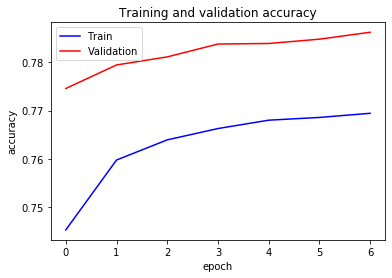

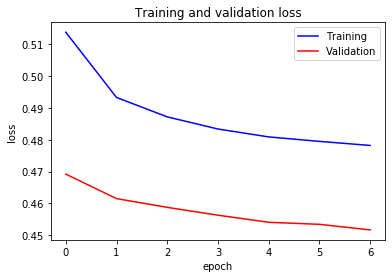

In [143]:
plt.plot(epochs, accuracy, 'b', label='Train')
plt.plot(epochs, val_accuracy, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()

In [60]:
# Sentiment threshold idea and prediction culled from https://github.com/y33-j3T/Twitter-Sentiment-Analysis-Flask-App/blob/master/utils.py

sentiment_score_threshold = (0.4, 0.7)

def sentiments(score, neutral_sentiment=True):
    if neutral_sentiment:        
        if score < sentiment_score_threshold[0]:
            sentiment = 'negative'
        elif score >= sentiment_score_threshold[1]:
            sentiment = 'positive'
        else:
            sentiment = 'neutral'

        return sentiment
    else:
        return 'negative' if score < 0.5 else 'positive'

In [84]:
def predict(model, tweets, neutral_sentiment=True, sequence_length=256):
    
    # Preprocess data
    tweets = [preprocess(t) for t in tweets]
    X = prep_data(tweets, train = False)
    # Prediction of new data
    score = model.predict(X, batch_size=1024)
    # sentiments
    sentiment_list = []
    for s in score:
        sentiment = sentiments(s, neutral_sentiment=neutral_sentiment)
        sentiment_list.append(sentiment)

    return {"sentiment": sentiment, "score": float(score)} 

In [85]:
predict(model, tweets = ["You are blessed"])

length of encoded docs:  1
Padded data shape: (1, 256)


{'sentiment': 'positive', 'score': 0.9513883590698242}

In [89]:
predict(model, tweets = ["I hate hunting"])

length of encoded docs:  1
Padded data shape: (1, 256)


{'sentiment': 'negative', 'score': 0.03280532732605934}

### Classification Report

In [92]:
scores = model.predict(X_test, verbose=1, batch_size=1024)
prediction = [sentiments(score, neutral_sentiment=False) for score in scores]


320000/320000 [==============================] - 31s 98us/step


In [93]:
y_test_original = list(test_sent_df.target)
print(classification_report(y_test_original, prediction))

              precision    recall  f1-score   support

    negative       0.80      0.76      0.78    160131
    positive       0.77      0.81      0.79    159869

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [94]:
accuracy_score(y_test_original, prediction)

0.786553125

## Predicting Sentiment on Covid 19 Tweets

### Fetching tweets

In [ ]:
def fetch_tweets(query, start_date, end_date, limit = 10000, language = "English"):
    """
    start_date: date in form year,month,day
    """

    tweets = query_tweets(query, begindate = start_date, enddate = end_date, limit = limit, lang = language)
    df = pd.DataFrame(t.__dict__ for t in tweets)
    return df

In [ ]:
start_date2 = dt.date(2020,2,1)
end_date2 = dt.date(2020,2,28)

start_date3 = dt.date(2020,3,1)
end_date3 = dt.date(2020,3,31)

start_date4 = dt.date(2020,4,1)
end_date4 = dt.date(2020,5,1)

limit = 25000
query = "coronavirus OR covid OR covid19 OR covid-19 OR corona virus OR #COVID19, OR #CoronavirusOutbreak" 

In [ ]:
tweets2 = fetch_tweets(query, start_date2, end_date2, limit = limit, language = 'english')

In [ ]:
tweets2.shape

In [ ]:
tweets2.to_csv (r'./data/tweets2.csv', index = False, header=True)

In [ ]:
tweets3 = fetch_tweets(query, start_date3, end_date3, limit = limit, language = 'english')

In [ ]:
tweets3.shape

In [ ]:
tweets3.to_csv (r'./data/tweets3.csv', index = False, header=True)

In [ ]:
tweets4 = fetch_tweets(query, start_date4, end_date4, limit = limit, language = 'english')

In [ ]:
tweets4.to_csv (r'./data/tweets4.csv', index = False, header=True)

In [ ]:
tweets4.shape

In [ ]:
tweets = pd.concat([tweets2, tweets3, tweets4])
tweets.to_csv (r'./data/tweets.csv', index = False, header=True)

In [47]:
tweets.head()

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
0,geziel_goes,Dr. Geziel Goes🇧🇷🇵🇹,4867434249,1233180006743969792,/geziel_goes/status/1233180006743969792,2020-02-27 23:59:59,1582847999,Se o Coronavirus esta derrubando a bolsa no Br...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,False,NaN,[]
1,Covid_19Time,COVID-19,1146021318082609152,1233180006655909888,/Covid_19Time/status/1233180006655909888,2020-02-27 23:59:59,1582847999,#Coronavirus #COVID19 \n\nIt’s going global @...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://twitter.com/Covid_19Time/status/1227...,...,True,['https://pbs.twimg.com/media/ER0irN5U0AADXHK....,NaN,26,8,2,True,False,NaN,[]
2,29Toninho,Toninho,585940381,1233180004030152704,/29Toninho/status/1233180004030152704,2020-02-27 23:59:58,1582847998,Bien por esa acción. Es difícil navegar por el...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,True,1.233054e+18,"[{'screen_name': 'Anaro74', 'user_id': '104697..."
3,BrendynMorgan,b,263311303,1233180001496969222,/BrendynMorgan/status/1233180001496969222,2020-02-27 23:59:58,1582847998,This damn Corona virus knocked my stocks all t...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,1,0,0,False,False,NaN,[]
4,BlindedSteer,Dusty Arth,460892027,1233179999605145600,/BlindedSteer/status/1233179999605145600,2020-02-27 23:59:57,1582847997,"@billburr So how many people are you secretly,...","<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,False,NaN,[]


In [96]:
#Extract language of each tweet 
tweets['text'] = tweets['text'].apply(lambda x:str(x)) #remove floats

tweets['language'] = tweets['text'].apply(cld3.get_language).map(lambda x: x[0]) #Get the language of each tweet

In [98]:
tweets = tweets[['text', 'language']]
tweets.head()

,text,language
0,Se o Coronavirus esta derrubando a bolsa no Br...,pt
1,#Coronavirus #COVID19 \n\nIt’s going global @...,no
2,Bien por esa acción. Es difícil navegar por el...,es
3,This damn Corona virus knocked my stocks all t...,mg
4,"@billburr So how many people are you secretly,...",en


## Obtain English tweets of interest

In [99]:
english_tweets = tweets[tweets['language']=='en']
english_tweets

,text,language
4,"@billburr So how many people are you secretly,...",en
5,What a smart thinking! While other countries s...,en
6,"Live!! Pope Sick With Corona Virus, 8 Chan Fou...",en
9,PM says #coronavirus is 10x more severe than f...,en
11,I'm obviously not a seasoned economist but my ...,en
...,...,...
41248,I’ll only ever hear corona virus in Cardi B’s ...,en
41249,"There it is folks, 18 months of lockdown minim...",en
41250,Do us a favor @realDonaldTrump just STFU when ...,en
41251,#ThankYOUgina !!!\nWhat an amazing woman! Amer...,en


In [100]:
english_tweets.shape

(20246, 2)

## Preprocess tweets

In [101]:
english_tweets['prep_text'] = english_tweets['text'].apply(preprocess)

In [102]:
english_tweets['prep_text']

4        many people secretly deep kinda sorta hoping c...
5        smart thinking country italy switzerland austr...
6        live pope sick corona virus 8 chan founder run...
9        pm say coronavirus 10x severe flu virus 10 tim...
11       obviously seasoned economist instinct blaming ...
                               ...                        
41248                 ever hear corona virus cardi b voice
41249    folk 18 month lockdown minimum forced vaccinat...
41250    u favor stfu come corona virus clearly clue ta...
41251    thankyougina amazing woman america winner covi...
41252    thing would grateful lazy fat fuck somebody st...
Name: prep_text, Length: 20246, dtype: object

## Dropping duplicate tweets

In [103]:
english_tweets = english_tweets.drop_duplicates(subset='text')

In [108]:
word_to_list = [word for line in english_tweets['prep_text'] for word in line.split()]
word_to_list[:20]

['many', 'people', 'secretly', 'deep', 'kinda', 'sorta', 'hoping', 'corona', 'virus', 'take', 'billy', '1', '2', 'billion', 'people', 'shhh', 'bud', 'tell', 'smart', 'thinking']

## Plotting Word Occurrence

In [109]:
occurence = Counter(word_to_list).most_common(50)
occurence_df = pd.DataFrame(occurence, columns=['word', 'frequency'])

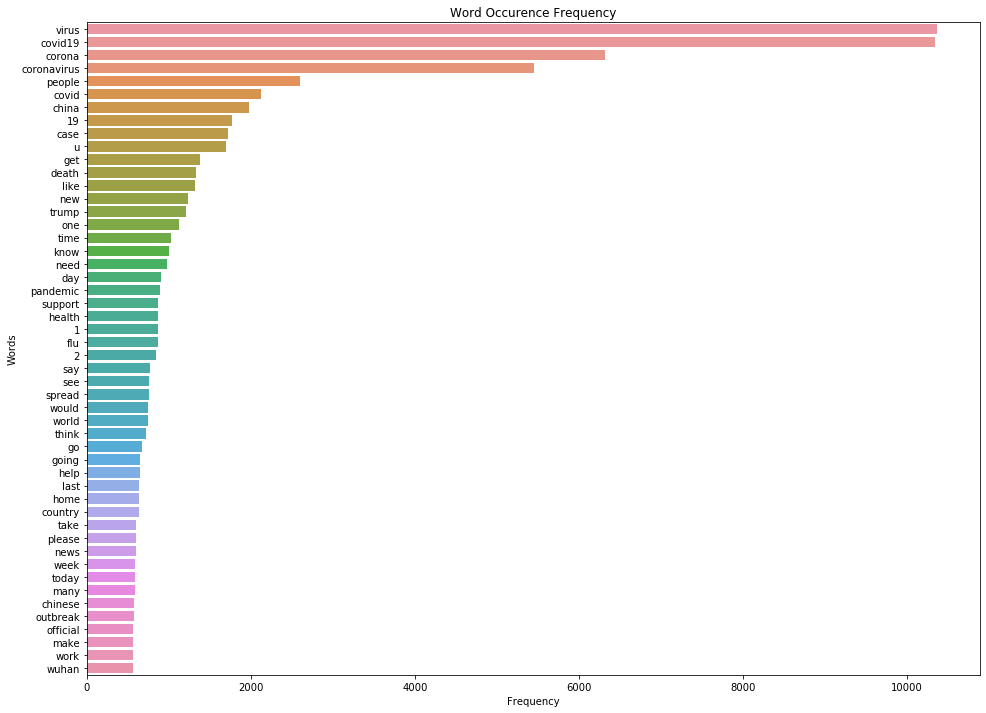

In [110]:
fig, ax = plt.subplots(figsize = (16, 12))
ax = sns.barplot(y="word", x='frequency', 
                 ax = ax, data=occurence_df
                    ).set(title = "Word Occurence Frequency", xlabel = 'Frequency', ylabel = 'Words' )

## Plotting the Word Cloud

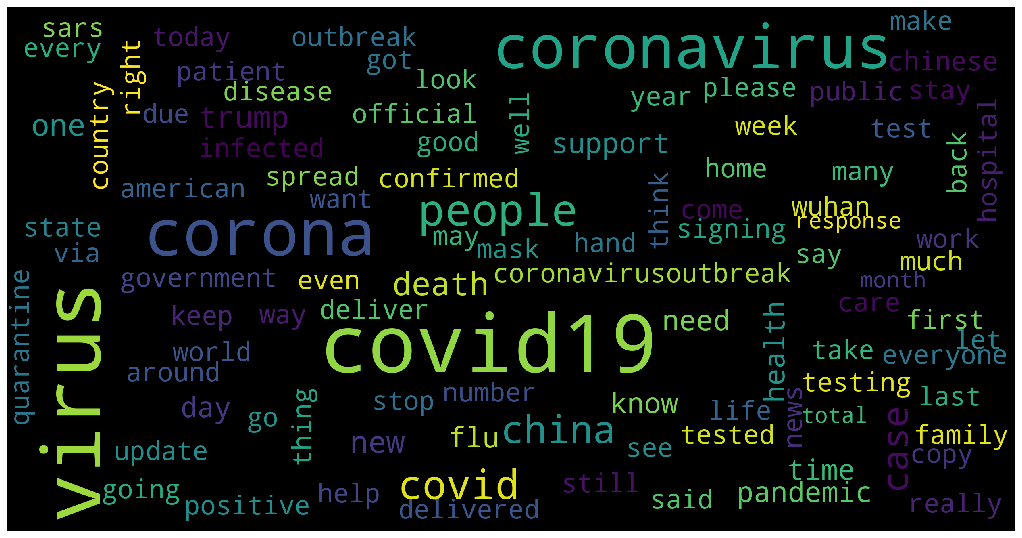

In [111]:
wordcloud = WordCloud(
    max_words=100,
    width=500,
    height=260,
    max_font_size=40, 
    scale=5,
    random_state=2,
    collocations=False,
    normalize_plurals=False
)

wordcloud.generate(' '.join(word_to_list))


plt.figure(figsize = (14, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Predicting Sentiment from Trained Model

In [ ]:
%%time
english_tweets['sentiments'] = english_tweets['prep_text'].apply(lambda x: predict(model, tweets = [x])['sentiment']);


In [125]:
english_tweets.to_csv('english_tweets_final.csv')

In [126]:
english_tweets

,text,language,prep_text,sentiments
4,"@billburr So how many people are you secretly,...",en,many people secretly deep kinda sorta hoping c...,negative
5,What a smart thinking! While other countries s...,en,smart thinking country italy switzerland austr...,neutral
6,"Live!! Pope Sick With Corona Virus, 8 Chan Fou...",en,live pope sick corona virus 8 chan founder run...,negative
9,PM says #coronavirus is 10x more severe than f...,en,pm say coronavirus 10x severe flu virus 10 tim...,negative
11,I'm obviously not a seasoned economist but my ...,en,obviously seasoned economist instinct blaming ...,neutral
...,...,...,...,...
41248,I’ll only ever hear corona virus in Cardi B’s ...,en,ever hear corona virus cardi b voice,negative
41249,"There it is folks, 18 months of lockdown minim...",en,folk 18 month lockdown minimum forced vaccinat...,neutral
41250,Do us a favor @realDonaldTrump just STFU when ...,en,u favor stfu come corona virus clearly clue ta...,neutral
41251,#ThankYOUgina !!!\nWhat an amazing woman! Amer...,en,thankyougina amazing woman america winner covi...,positive


In [130]:
sentiment_counts_NN = pd.DataFrame.from_dict(Counter(english_tweets['sentiments']), orient = 'index').reset_index()
sentiment_counts_NN.columns = ['sentiments', 'frequency']
sentiment_counts_NN

,sentiments,frequency
0,negative,10073
1,neutral,6408
2,positive,2938


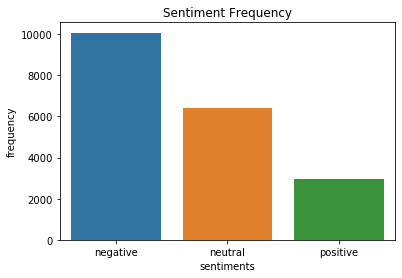

In [131]:
sns.barplot(y="frequency", x='sentiments', data=sentiment_counts_NN).set(title = 'Sentiment Frequency')
plt.show()

## Sentiment Analysis using SentimentIntensityAnalyzer

In [135]:
#polarity score for each tweet
sia_object = SentimentIntensityAnalyzer()
polarity_scores = english_tweets['prep_text'].apply(lambda x: sia_object.polarity_scores(x))

polarity_scores_df = pd.DataFrame(list(polarity_scores))
polarity_scores_df.head()

,neg,neu,pos,compound
0,0.000,0.871,0.129,0.3024
1,0.000,0.685,0.315,0.7783
2,0.401,0.599,0.000,-0.7717
3,0.380,0.620,0.000,-0.8555
4,0.276,0.421,0.304,0.1531


## Categorizing sentiments as positive, negative or neutral

In [136]:
polarity_scores_df['sentiment'] = polarity_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
polarity_scores_df.head()


,neg,neu,pos,compound,sentiment
0,0.000,0.871,0.129,0.3024,positive
1,0.000,0.685,0.315,0.7783,positive
2,0.401,0.599,0.000,-0.7717,negative
3,0.380,0.620,0.000,-0.8555,negative
4,0.276,0.421,0.304,0.1531,positive


In [137]:
sentiment_counts = pd.DataFrame.from_dict(Counter(polarity_scores_df['sentiment']), orient = 'index').reset_index()
sentiment_counts.columns = ['sentiment', 'frequency']
sentiment_counts

,sentiment,frequency
0,positive,7865
1,negative,8255
2,neutral,3299


## Plotting sentiment frequency

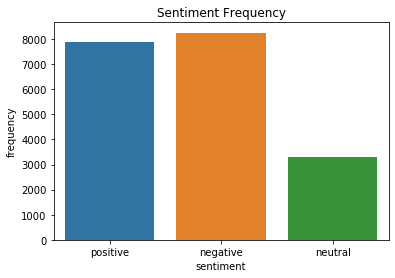

In [138]:
sns.barplot(y="frequency", x='sentiment', data=sentiment_counts).set(title = 'Sentiment Frequency')
plt.show()

It appears there are lots of misclassification of sentiment labels in `SentimentIntensityAnalyzer` method.

## References

1. https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis

2. https://github.com/y33-j3T/Twitter-Sentiment-Analysis-Flask-App/blob/master/utils.py

3. https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

4. https://github.com/UBC-MDS/DSCI_575_adv-mach-learn